# Feature importance and selection methods

Since there is no golden recipe for feature selection and it is more an art than a science based on experimentations we will implement several methods. Some of the methods are bivariate in nature and others are model-based. Bivariate methods alone are tricky since while initially removing a feature with low (cor)relation might sound like a good idea, the interaction of that same variable with another variable might be important to predict the target. Also looking at for example correlation only would imply looking only at possible linear relations while ther might be (an even stronger) non-linear relation (if related to a linear model later in the pipeline like linear regression). In addition, without using models which take also into account interactions (like tree methods) we might miss out on some important features. Hence the reason for using several methods. We use the following:

* Correlations & Phik (bivariate methods)
* Sequential Feature Selection methods (model based methods)
* Extra Trees, XGB (model (regularized) based methods) 
* Lasso(CV) (model (regularized) based methods)

The general setup for each of the model based feature selection methods is that we run the selection method, plot the feature importances, save the features and show the performance on the testset to get an initial feeling on model performance. Note that these experimentsal results are _not_ on our formal train and test set (which we will introduce further in the next notebook **4. Modelling.ipynb**). 

Moreover we run a PCA just to get an idea on the dimensionality of our data.

This notebook will come to a conclusion on how we want to proceed in terms of which features we will use for modelling. 

### Import libraries

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 999

import pickle

import numpy as np

import warnings
warnings.filterwarnings('ignore')

import gc
from datetime import datetime

# scaling, modelling and metrics
from sklearn.utils import shuffle
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV, Lasso
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor
from xgboost import plot_importance

# feature selection methods
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# statistics
import phik

# visualisations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# save files
from joblib import dump, load

# custom functions
from model_performance_rides import metrics_feat_sel
from reduce_memory import reduce_mem_usage

### Read in data

In [2]:
# read in the file and preprocess data from notebook 3.1 Feature Engineering.ipynb

def read_file(filename):
    df = pd.read_pickle(filename)
    '''
    Returns a DataFrame for further processing

            Parameters:
                    filename: (str) pickle object name
                    
            Returns:
                    pd.DataFrame: pandas DataFrame for further processing
    '''    
    # We swap the hr column since we want that to be the first column (when showing correlations)
    cols = list(df.columns)
    a, b = cols.index('hr'), cols.index('secs')
    cols[b], cols[a] = cols[a], cols[b]
    df = df[cols]
    
    df = reduce_mem_usage(df)
    
    return df

df_raw = read_file('df_modelset_rider1_4.pkl')

Memory usage after optimization is: 3386.39 MB
Decreased by 0.0%


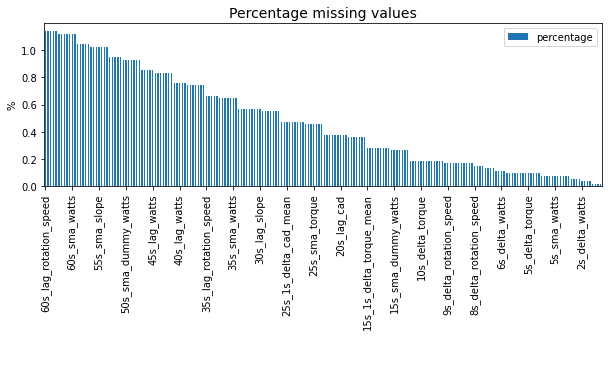

In [6]:
# Get overview of missing values

((df_raw.isnull().sum())/len(df_raw)*100).to_frame(name='percentage').query('percentage > 0').sort_values(by='percentage', ascending=False).plot(kind='bar',figsize=(10,3))
xticks = plt.gca().xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i % 10 != 0:
        xticks[i].set_visible(False)
plt.ylabel('%')
plt.title('Percentage missing values', fontsize=14);

**Observations** 

We see that we have created some missing values, because of our lag and moving average variables. It is logical that the longest range now comes from the 60s lag/moving period. We will drop these missing rows which occur at the beginning of the rides. The smaller time window missings are dealt with automatically as well. The consequence is that we might loose the first 60 seconds of a ride if the 60s variable(s) relate highly to our target heart rate. We will see that later in this notebook.

One more remark. In the notebook **0. Data exploration.ipynb** we identified strange values for temperature (-255). We will experiment later if we want to model further with this temperature data. If yes, we will take out rides which those odd values. For now take that into account when looking at the feature importance

Before we start we will define some datasets for our analyses. Since some procedures are very memory intensive we make some smaller datasets first. We will use approximately half of all the rides in our analyses. These datasets are used for our model-based feature importance procedures.

In [7]:
# make sample files

number_of_files = np.round((df_raw.filename.nunique()/2),0).astype(int) # half the dataset of rides. Note we divide rides not datapoints

# shuffle 
df_raw_files = shuffle(df_raw.filename.unique(), random_state = 101)
df_raw_files = df_raw_files[:number_of_files]

# The id sets contain the filenames which are in train and test set
X_train_id, X_test_id = train_test_split(df_raw_files, test_size=0.25, random_state=42)

# Train sets
X_train_tot = df_raw[df_raw['filename'].isin(X_train_id)]
X_train_tot = X_train_tot.dropna()

y_train = X_train_tot.hr
X_train = X_train_tot.drop(columns=['hr', 'filename', 'date', 'Date', 'time', 'TRIMP(100)_Points', 'TRIMP_Points', 'TRIMP_Zonal_Points'])

# Test sets
X_test_tot = df_raw[df_raw['filename'].isin(X_test_id)]
X_test_tot = X_test_tot.dropna()

y_test = X_test_tot.hr
X_test = X_test_tot.drop(columns=['hr', 'filename', 'date', 'Date', 'time', 'TRIMP(100)_Points', 'TRIMP_Points', 'TRIMP_Zonal_Points'])

### Bivariate metrics: (Pearson) Correlations and Phik 

### Correlations

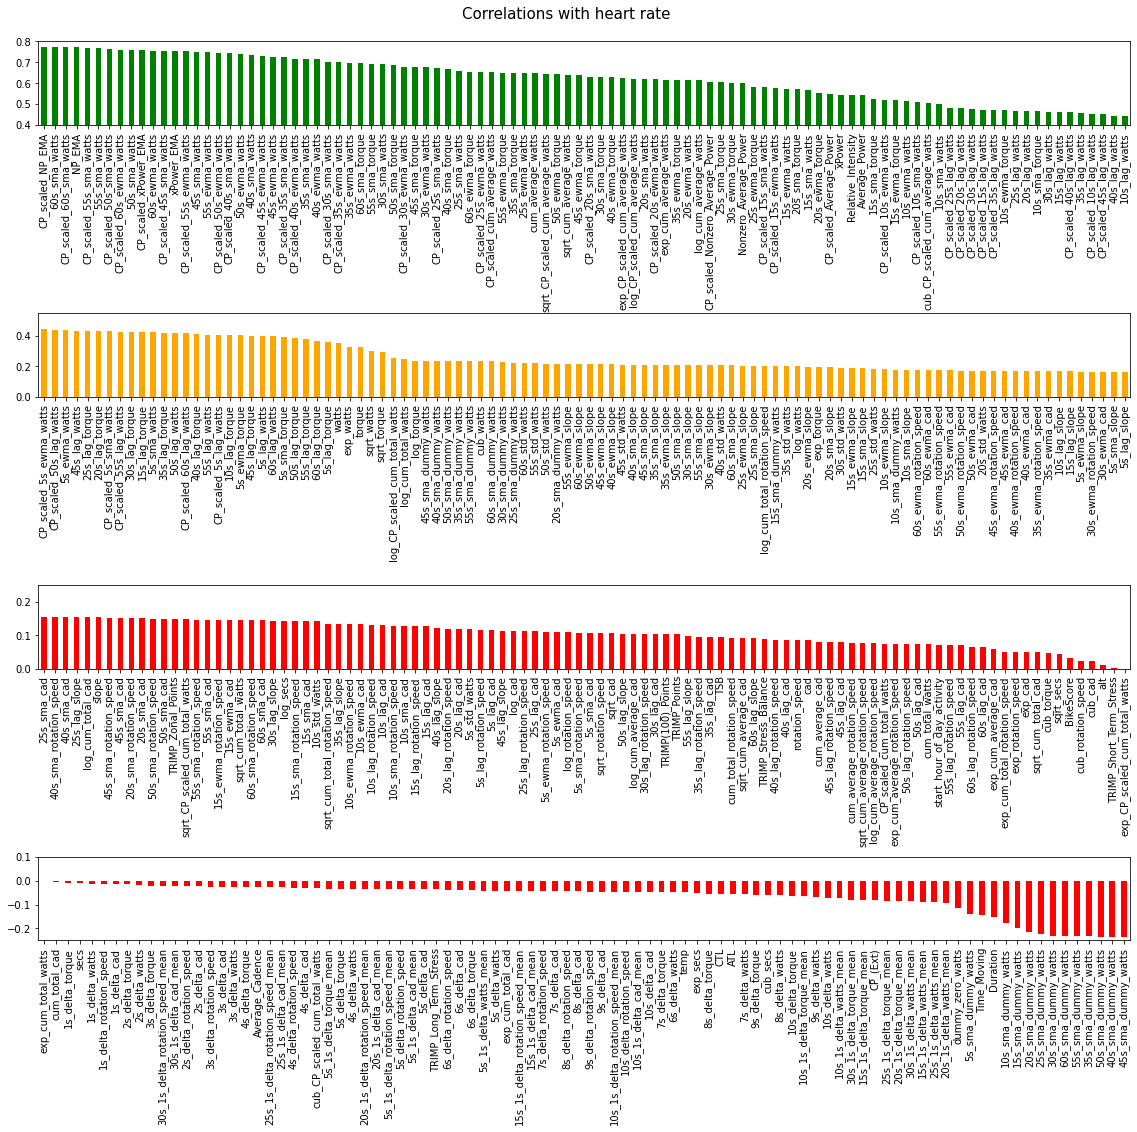

In [9]:
# Note since we have variables with NaN coming from the rolling features the maximum (in this case first 60 seconds for each file) are omitted
# This is however not a big issue since for now we want to get a view on the relations in general

# Create correlation matrix
df_corr = df_raw.select_dtypes(include=np.number).corr().iloc[:,0]

# Plot the correlations with heart rate
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(4, 1,figsize=(16,16))

abs(df_corr[1:]).sort_values(ascending=False)[:100].plot(kind='bar', ax=ax1, color='green')
abs(df_corr[1:]).sort_values(ascending=False)[100:200].plot(kind='bar', ax=ax2, color='orange')
df_corr[1:].sort_values(ascending=False)[200:300].plot(kind='bar', ax=ax3, color='red')
df_corr[1:].sort_values(ascending=False)[300:len(df_corr[1:])].plot(kind='bar', ax=ax4, color='red')

ax1.set_ylim([0.4,0.8]);
ax2.set_ylim([0,0.55]);
ax3.set_ylim([0,0.25]);
ax4.set_ylim([-0.25,0.1]);

ax1.set_ylabel('correlation')
ax2.set_ylabel('correlation')
ax3.set_ylabel('correlation')
ax4.set_ylabel('correlation')

plt.tight_layout()

fig.subplots_adjust(top=0.95)
fig.suptitle('Correlations with heart rate', fontsize=15);

# delete df_raw since we won't need it further in the notebook
del df_raw
gc.collect();

### Phi_K

In [8]:
# Create Phi_K matrix on a smaller subset (testset defined) since Phik takes a long time to compute. Also memory issues can arise

# The variables we want to calculate are the top 100 based on correlations on in the testset. For first 50 and second 50 we calculate Phik

# We also calculate same correlations but then on testset just to get an idea when comparing the relations with heart rate

df_corr_test = X_test_tot.select_dtypes(include=np.number).corr().iloc[:,0]

int_cols1 = df_corr_test.sort_values(ascending=False).index[0:50].to_list()
df_phik1 = X_test_tot[int_cols1].phik_matrix(interval_cols = int_cols1).iloc[:,0];

int_cols2 = df_corr_test.sort_values(ascending=False).index[50:100].to_list()
int_cols2.insert(0, "hr")
df_phik2 = X_test_tot[int_cols2].phik_matrix(interval_cols = int_cols2).iloc[:,0];

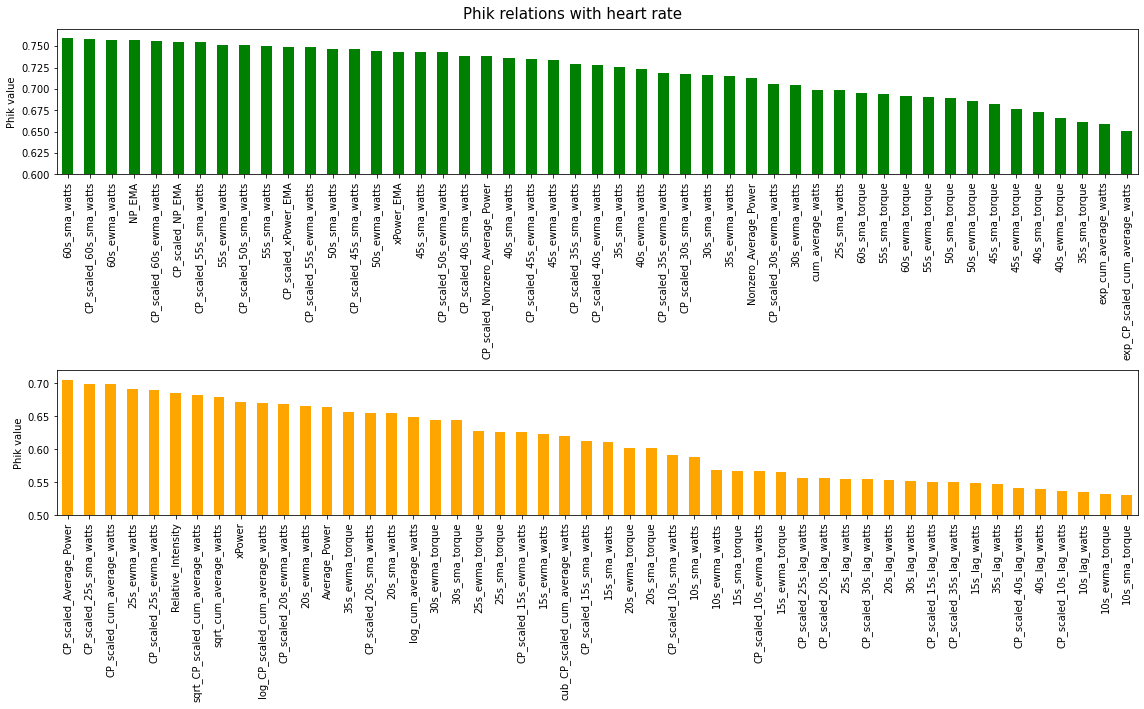

In [60]:
# visualize Phik metrics

fig, ((ax1, ax2)) = plt.subplots(2, 1,figsize=(16,10))

abs(df_phik1[1:]).sort_values(ascending=False).plot(kind='bar', ax=ax1, color='green')
abs(df_phik2[1:]).sort_values(ascending=False).plot(kind='bar', ax=ax2, color='orange')

ax1.set_ylim([0.6,0.77]);
ax2.set_ylim([0.5,0.72]);

ax1.set_ylabel('Phik value')
ax2.set_ylabel('Phik value')

fig.subplots_adjust(top=0.95)
fig.suptitle('Phik relations with heart rate', fontsize=15);

plt.tight_layout()

We visualize the index of Phi_K and Correlations to show in general the relation between heart rate and top 100 variables based on correlation is slightly more non-linear

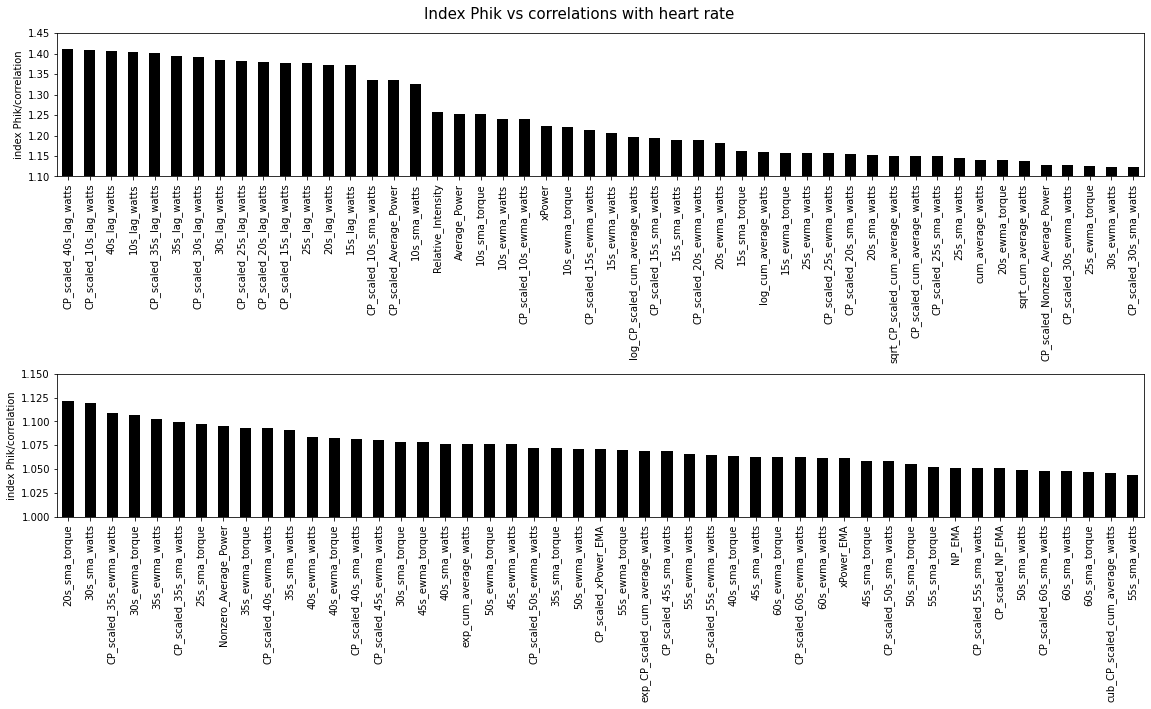

In [12]:
# Visualize the indices

fig, ((ax1, ax2)) = plt.subplots(2, 1,figsize=(16,10))

(df_phik1[1:].append(df_phik2[1:]).sort_index(ascending=False) / df_corr_test.sort_values(ascending=False)[0:100][1:].sort_index(ascending=False)).sort_values(ascending=False)[:50].plot(kind='bar', color='black', ax=ax1)

(df_phik1[1:].append(df_phik2[1:]).sort_index(ascending=False) / df_corr_test.sort_values(ascending=False)[0:100][1:].sort_index(ascending=False)).sort_values(ascending=False)[50:100].plot(kind='bar', color='black', ax=ax2)

ax1.set_ylim([1.1,1.45]);
ax2.set_ylim([1,1.15]);

ax1.set_ylabel('index Phik/correlation')
ax2.set_ylabel('index Phik/correlation')

fig.subplots_adjust(top=0.95)
fig.suptitle('Index Phik vs correlations with heart rate', fontsize=15);

plt.tight_layout()

**Observations** 

* In general we see that CP scaled wattages tend appear higher in the correlation rankings then their non-scaled counterparts
* In general the larger the window (or lag) the higher the correlation
* Some variables tend to correlate highly with heart rate (e.g. 60s CP scaled sma watts, 0.77). However these variables also correlate highly among each other (which is logical given the nature 
of the rolling variables). This brings issues with multicollinearity. However, since we are not primarly interested in estimating coefficients, but more in prediction, this is less of an issue. We could balance the use of these variables with the addition to predictive power. An example would be to not use both 
sma_60s_watts and sma_50s_watts, but only the one with highest (cor)relation.

It is also apparent that (at least the top 100 variables based on correlations) have a more non-linear relation with heart rate. 
This can point in the direction that when not individually corrected for this non-linearity a linear model might not perform as well as 
a model which can deal with non-linear relations (and interactions). 

## Sequential methods

### Sequential Feature Selection Forward (FS)

In [50]:
# instantiate linear regression. Our selection method goes to 50 features maximum
lin_reg_sfs = LinearRegression()

sfs = SFS(lin_reg_sfs, 
          k_features=50, 
          forward=True, 
          floating=False, 
          scoring='neg_root_mean_squared_error',#'neg_mean_squared_error'
          verbose=0,
          cv=3)

sfs = sfs.fit(X_train, y_train)

In [58]:
# RMSE of the feature selection method
print('RMSE', -sfs.k_score_)

# Pickle dictionary for later use
np.save('sfs_dict_results.npy', sfs.get_metric_dict()) 

# Load
#read_dictionary = np.load('sfs_dict_results.npy',allow_pickle='TRUE').item()

RMSE 7.937374500345272


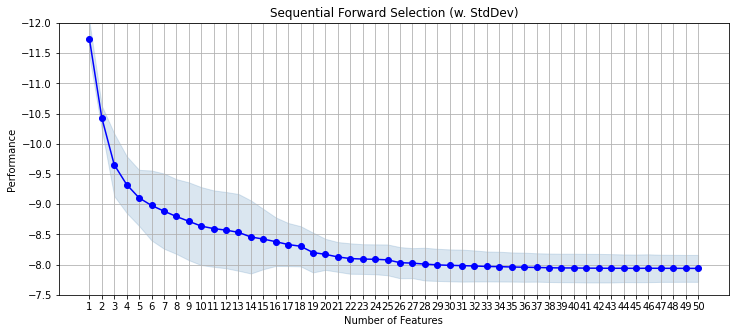

In [56]:
# plot the feature selection (negative) RMSE development
fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev',figsize=(12,5))

plt.ylim([-7.5, -12])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [57]:
# Make DataFrame with results and save for possible later use
df_sfs_model_results = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
df_sfs_model_results.to_pickle('df_sfs_model_results.pkl')

# Make DataFrame with top 50 features and save for possible later use
df_sfs = pd.DataFrame({'feature_names': list(sfs.subsets_.get(50).get('feature_names'))})
df_sfs['forward'] = 1
df_sfs.to_pickle('df_sfs_importances.pkl')

In [135]:
# Select the top 50 features
sel_sfs_vars = df_sfs.feature_names.tolist()

# Run a normal regression on top 50 features
sklearn_sfs_linreg = LinearRegression().fit(X_train[sel_sfs_vars], y_train)

# Get initial idea on performance RMSE, R2
df_metrics_sfs_linreg = metrics_feat_sel(X_test[sel_sfs_vars], X_test_tot, y_test, sklearn_sfs_linreg, 'model_sfs_linreg', scaled_test_set = False)

# pickle for later use
df_metrics_sfs_linreg.to_pickle('df_metrics_sfs_linreg.pkl')

Mean RMSE over files 8.227245882076454
Total RMSE 8.596451298010747
R2 test 0.7872617525958296


### Sequential Feature Selection Stepwise (FS)

In [61]:
# instantiate linear regression. Our selection method goes to 50 features maximum
lin_reg_sfr = LinearRegression()

sfr = SFS(lin_reg_sfr, 
          k_features=50, 
          forward=True, 
          floating=True, 
          scoring='neg_root_mean_squared_error',
          verbose=0,
          cv=2)

sfr = sfr.fit(X_train, y_train)

In [62]:
# RMSE of the feature selection method
print('RMSE', -sfr.k_score_)

#Pickle dictionary for later use
np.save('sfr_dict_results.npy', sfr.get_metric_dict()) 

RMSE 7.22248850177817


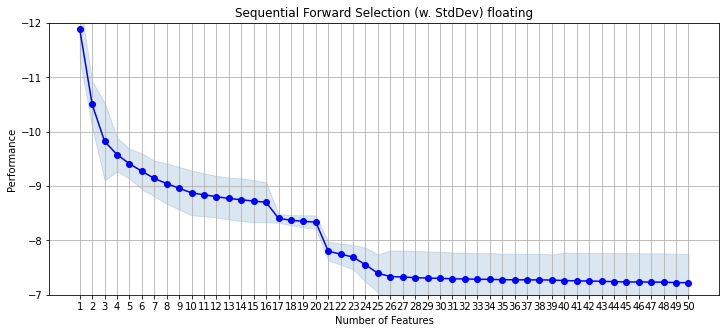

In [63]:
# plot the feature selection (negative) RMSE development
fig = plot_sfs(sfr.get_metric_dict(), kind='std_dev',figsize=(12,5))

plt.ylim([-7.0, -12])
plt.title('Sequential Forward Selection (w. StdDev) floating')
plt.grid()
plt.show()

In [137]:
# Make DataFrame with results and save for possible later use
df_sff_model_results = pd.DataFrame.from_dict(sfr.get_metric_dict()).T
df_sff_model_results.to_pickle('df_sff_model_results.pkl')

# Make DataFrame with top 50 features and save for possible later use
df_sff = pd.DataFrame({'feature_names': list(sfr.subsets_.get(50).get('feature_names'))})
df_sff['sequential'] = 1
df_sff.to_pickle('df_sff_importances.pkl')

In [138]:
# Select the top 50 features
sel_sff_vars = df_sff.feature_names.tolist()

# Run a normal regression on top 50 features
sklearn_sff_linreg = LinearRegression().fit(X_train[sel_sff_vars], y_train)

# Get initial idea on performance RMSE, R2
df_metrics_sff_linreg = metrics_feat_sel(X_test[sel_sff_vars], X_test_tot, y_test, sklearn_sff_linreg, 'model_sff_linreg', scaled_test_set = False)

# pickle for later use
df_metrics_sff_linreg.to_pickle('df_metrics_sff_linreg.pkl')

Mean RMSE over files 7.142759891795502
Total RMSE 7.47001659657204
R2 test 0.8393612572884056


## Tree based methods

We use two three based methods. ExtraTrees and XGB

### ExtraTrees (FS)

In [191]:
# Build a forest and compute the impurity-based feature importances
forest_extra_tree = ExtraTreesRegressor(n_estimators=250,
                              random_state=101)

forest_extra_tree.fit(X_train, y_train)

ExtraTreesRegressor(n_estimators=250, random_state=101)

In [ ]:
# save model for possible future use
dump(forest_extra_tree, 'feature_selection_extratrees.joblib') 

# forest_extra_tree = load('feature_selection_extratrees.joblib') 

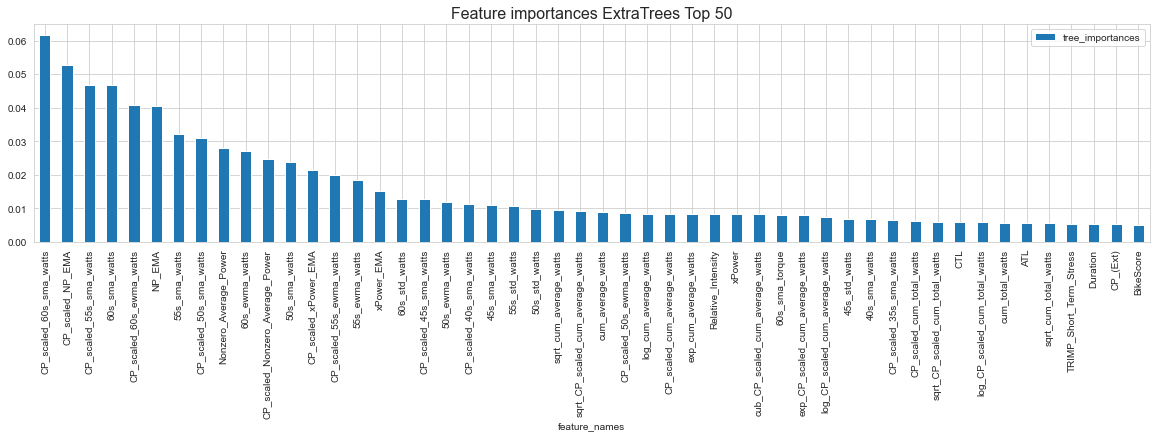

In [221]:
# Select indices and feature importances
importances_tree = forest_extra_tree.feature_importances_
indices_tree = np.argsort(importances_tree)[::-1]

# Make DataFrame
df_tree_importances = pd.DataFrame(np.column_stack((X_train.columns[indices_tree.tolist()] , importances_tree[indices_tree])), columns =['feature_names','tree_importances']).set_index('feature_names')
df_tree_importances['tree_importances'] = pd.to_numeric(df_tree_importances.tree_importances, errors='coerce')

# Make visualisation
df_tree_importances.sort_values(by='tree_importances', ascending=False)[:50].plot(kind='bar', figsize=(20,4))
plt.title('Feature importances ExtraTrees Top 50', fontsize=16);

# save file as pickle for later use
df_tree_importances.sort_values(by='tree_importances', ascending=False).to_pickle('df_tree_importances.pkl');

In [197]:
# Get initial idea on performance RMSE, R2
df_metrics_extra_trees = metrics_feat_sel(X_test, X_test_tot, y_test, forest_extra_tree, 'model_extra_trees', scaled_test_set = False)

# pickle for later use
df_metrics_extra_trees.to_pickle('df_metrics_extra_trees.pkl')

Mean RMSE over files 7.074189437364981
Total RMSE 7.807634569387759
R2 test 0.8245125272889533


### XGBoost regressor (FS)

In [39]:
# instantiate model
model_XGB = XGBRegressor()

# define eval set
eval_set = [(X_train, y_train), (X_test, y_test)]

# fit the model
model_XGB.fit(X_train, y_train, early_stopping_rounds=15, eval_metric=["rmse"], eval_set = eval_set, verbose=False)

# retrieve performance metrics
results = model_XGB.evals_result()

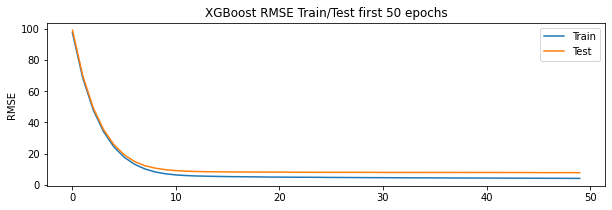

In [40]:
# plot rmse development over iterations
epochs = len(results['validation_0']['rmse'])

x_axis = range(0,50)

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(x_axis, results['validation_0']['rmse'][:50], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'][:50], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE Train/Test first 50 epochs')
plt.show()

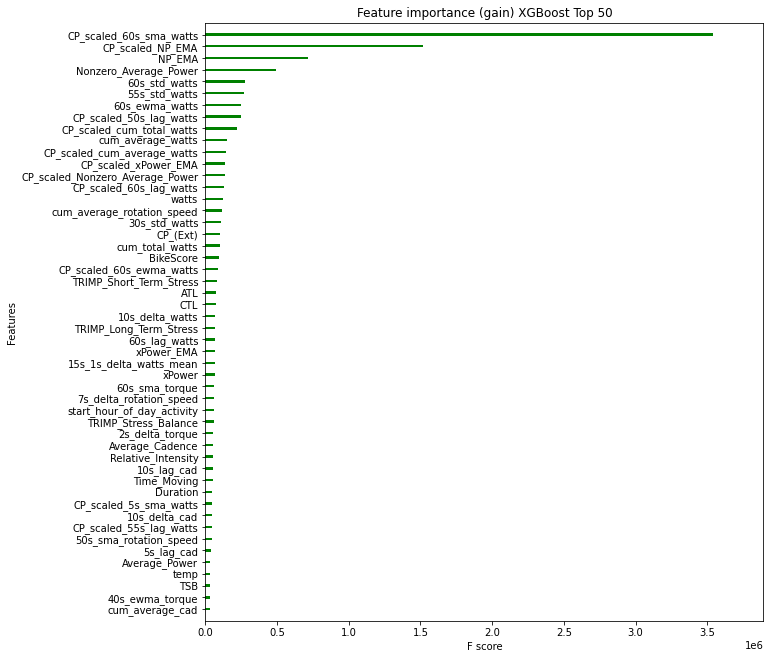

In [41]:
# provide the importance dictionary to the plotting function
fig, ax = plt.subplots(1, 1,figsize=(10,11))
plot_importance(model_XGB, max_num_features=50, importance_type='gain', title='Feature importance (gain) XGBoost Top 50', show_values=False, ax=ax, grid=False, color='green');

In [42]:
# make a DataFrame from the tree importances (based on gain) and save
df_xgb_importances = pd.DataFrame(model_XGB.get_booster().get_score(importance_type='gain').items(), columns=['feature_names', 'XGB_importances']).set_index('feature_names')

# save file as pickle for later use
df_xgb_importances.sort_values(by='XGB_importances', ascending=False).to_pickle('df_xgb_importances.pkl');

In [43]:
# save model for possible future use
dump(model_XGB, 'feature_selection_model_XGB.joblib')

['feature_selection_model_XGB.joblib']

In [101]:
# Get initial idea on performance RMSE, R2
df_metrics_XGB = metrics_feat_sel(X_test, X_test_tot, y_test, model_XGB, 'model_XGB', scaled_test_set = False)

# pickle for later use
df_metrics_XGB.to_pickle('df_metrics_XGB.pkl')

Mean RMSE over files 7.280601095907467
Total RMSE 7.721014
R2 test 0.8283847875298461


In [45]:
# Say we cut off the model at 15 iterations
model_XGB_15 = XGBRegressor(n_estimators=15)

# define eval set
eval_set = [(X_train, y_train), (X_test, y_test)]

# fit the model
model_XGB_15.fit(X_train, y_train, early_stopping_rounds=15, eval_metric=["rmse"], eval_set=eval_set, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=15, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

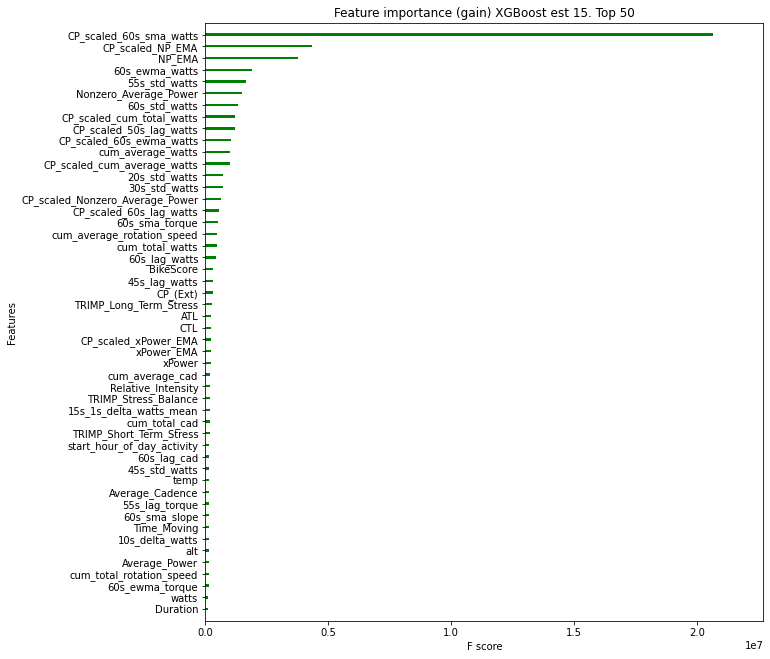

In [46]:
# provide the importance dictionary to the plotting function
fig, ax = plt.subplots(1, 1,figsize=(10,11))
plot_importance(model_XGB_15, max_num_features=50, importance_type='gain', title='Feature importance (gain) XGBoost est 15. Top 50', show_values=False, ax=ax, grid=False, color='green');

In [47]:
# make a DataFrame from the tree importances (based on gain) and save
df_xgb_15_importances = pd.DataFrame(model_XGB_15.get_booster().get_score(importance_type='gain').items(), columns=['feature_names', 'XGB_15_importances']).set_index('feature_names')

# save file as pickle for later use
df_xgb_15_importances.sort_values(by='XGB_15_importances', ascending=False).to_pickle('df_xgb_15_importances.pkl');

In [48]:
# save model for possible future use
dump(model_XGB_15, 'feature_selection_model_XGB_15.joblib') 

['feature_selection_model_XGB_15.joblib']

In [103]:
# Get initial idea on performance RMSE, R2
df_metrics_XGB_15 = metrics_feat_sel(X_test, X_test_tot, y_test, model_XGB_15, 'model_XGB_15', scaled_test_set = False)

# pickle for later use
df_metrics_XGB_15.to_pickle('df_metrics_XGB_15.pkl')

Mean RMSE over files 7.745262010810301
Total RMSE 8.322831
R2 test 0.8005888402905911


## Model based (regularization) methods

###  Lasso CV (FS)

We use the standard scaler to standardize the features before we use Lasso. If we don't standardize the features there will be bias in selection because features are on different scales. We use the L1 prior and no L2 penalty (default sklearn setting)

In [14]:
# instantiate scaler
scaler = StandardScaler()

# fit scaler
scaler.fit(X_train)

# make scaled datasets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
# Apply LassoCV. Note we only take the trainset into account
model_lasso_cv = LassoCV(random_state=101).fit(X_train_scaled, y_train)

In [36]:
# save model for possible future use
dump(model_lasso_cv, 'feature_selection_model_lasso_cv.joblib') 

['feature_selection_model_lasso_cv.joblib']

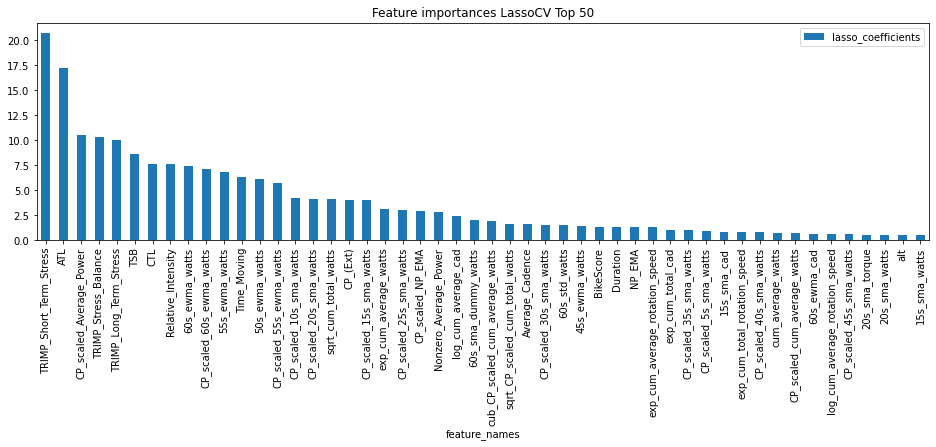

In [85]:
# Select indices and feature importances
importances_lasso_cv = np.abs(model_lasso_cv.coef_)
indices_cv = np.argsort(importances_lasso_cv)[::-1]

# Make DataFrame based on coefficients
lasso_importances_cv = pd.DataFrame(np.column_stack((X_train.columns[indices_cv.tolist()] , importances_lasso_cv[indices_cv])), columns =['feature_names','lasso_coefficients']).set_index('feature_names')
lasso_importances_cv['lasso_coefficients'] = pd.to_numeric(lasso_importances_cv.lasso_coefficients, errors='coerce')

# Make visualisation
lasso_importances_cv.sort_values(by='lasso_coefficients', ascending=False)[:50].plot(kind='bar', figsize=(16,4))
plt.title('Feature importances LassoCV Top 50');

# Save file as pickle for later use
lasso_importances_cv.sort_values(by='lasso_coefficients', ascending=False).to_pickle('lasso_cv_importances.pkl');

In [121]:
# Get initial idea on performance RMSE, R2
df_metrics_Lasso_cv = metrics_feat_sel(X_test_scaled, model_lasso_cv, 'model_lasso_cv', scaled_test_set = True)

# pickle for later use
df_metrics_Lasso_cv.to_pickle('df_metrics_Lasso_cv.pkl')

Mean RMSE over files 7.0804130687869185
Total RMSE 7.451719791145757
R2 test 0.8401472197350903


### Lasso CV with Linear Regression

In [118]:
# A normal regression model with the top 50 selected coefficients 
lasso_importances_cv['lasso_importances'] = pd.to_numeric(lasso_importances_cv.lasso_coefficients, errors='coerce')

#selections from lassocv
sels = lasso_importances_cv.sort_values(by='lasso_importances', ascending=False)[:50].index.to_list()

# fit the model
sklearn_regr_model = LinearRegression().fit(X_train[sels], y_train)

# Get initial idea on performance RMSE, R2
df_metrics_Lasso_cv_linreg = metrics_feat_sel(X_test[sels], X_test_tot, y_test, sklearn_regr_model, 'model_lasso_cv_linreg', scaled_test_set = False)

# pickle for later use
df_metrics_Lasso_CV_linreg.to_pickle('df_metrics_Lasso_cv_linreg.pkl')

Mean RMSE over files 7.04969131740404
Total RMSE 7.444725689961924
R2 test 0.8404471509905299


### Lasso normal (FS)

In [15]:
# Apply Lasso. Note we only take the trainset into account
model_lasso_normal = Lasso(random_state=101).fit(X_train_scaled, y_train)

In [33]:
# save model for possible future use
dump(model_lasso_normal, 'feature_selection_model_lasso_normal.joblib') 
# forest = load('feature_selection_model_lasso_normal.joblib') 

['feature_selection_model_lasso_normal.joblib']

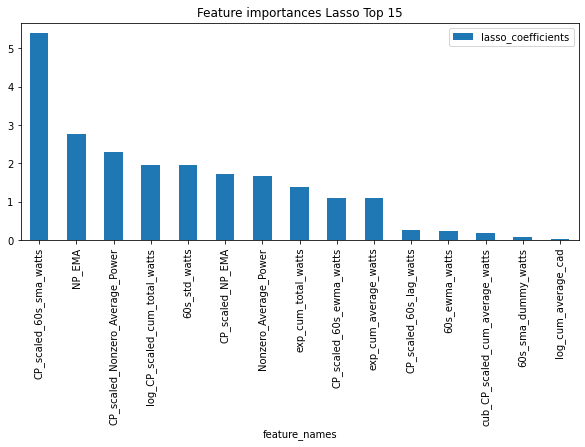

In [29]:
# Select indices and feature importances
importances_lasso = np.abs(model_lasso_normal.coef_)
indices_lasso = np.argsort(importances_lasso)[::-1]

# Make DataFrame based on coefficients
lasso_importances = pd.DataFrame(np.column_stack((X_train.columns[indices_lasso.tolist()] , importances_lasso[indices_lasso])), columns =['feature_names','lasso_coefficients']).set_index('feature_names')
lasso_importances['lasso_coefficients'] = pd.to_numeric(lasso_importances.lasso_coefficients, errors='coerce')

# Make visualisation
lasso_importances.sort_values(by='lasso_coefficients', ascending=False)[:15].plot(kind='bar', figsize=(10,4))
plt.title('Feature importances Lasso Top 15');

# Save file as pickle for later use
lasso_importances.sort_values(by='lasso_coefficients', ascending=False).to_pickle('lasso_importances.pkl');

In [109]:
# Get initial idea on performance RMSE, R2
df_metrics_Lasso = metrics_feat_sel(X_test_scaled, X_test_tot, y_test, model_lasso_normal, 'model_lasso_normal', scaled_test_set = True)

# pickle for later use
df_metrics_Lasso.to_pickle('df_metrics_Lasso.pkl')

Mean RMSE over files 9.9222272536815
Total RMSE 10.186577292333583
R2 test 0.7012803907286883


### Lasso normal with Linear Regression

In [130]:
# A normal regression model with the top selected coefficients
lasso_importances['lasso_importances'] = pd.to_numeric(lasso_importances.lasso_coefficients, errors='coerce')

#selections from lasso
sels = lasso_importances.sort_values(by='lasso_importances', ascending=False)[:15].index.to_list()

# fit the model
sklearn_regr_model = LinearRegression().fit(X_train[sels], y_train)

# Get initial idea on performance RMSE, R2
df_metrics_Lasso_linreg = metrics_feat_sel(X_test[sels], X_test_tot, y_test, sklearn_regr_model, 'model_lasso_linreg', scaled_test_set = False)

# pickle for later use
df_metrics_Lasso_linreg.to_pickle('df_metrics_Lasso_linreg.pkl')

Mean RMSE over files 9.707167811256204
Total RMSE 9.842262900729127
R2 test 0.7211330249068986


Now that we -next to the features selected in the models- we also got a small grasp on _possible_ directions for model performance. We will plot those below

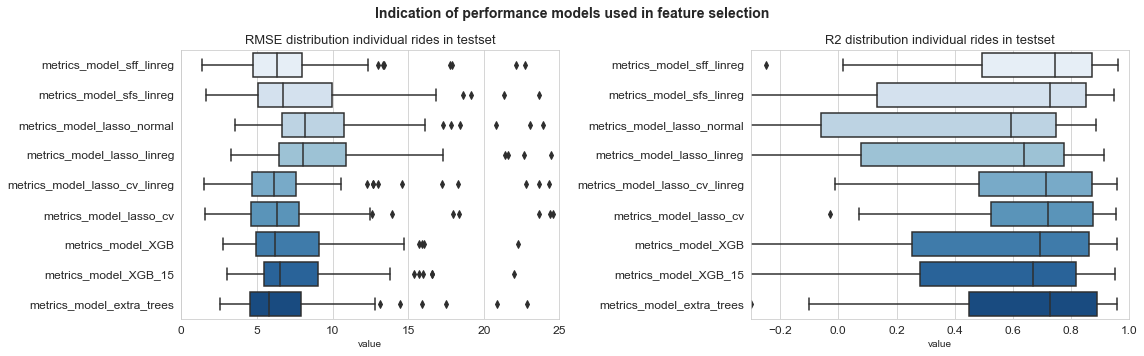

In [198]:
# visualise indication performances
sns.set_style("whitegrid")

fig, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(16,5))

cdf = pd.concat([df_metrics_sff_linreg, df_metrics_sfs_linreg, df_metrics_Lasso, df_metrics_Lasso_linreg, df_metrics_Lasso_cv_linreg, df_metrics_Lasso_cv, df_metrics_XGB, df_metrics_XGB_15, df_metrics_extra_trees])    
mdf = pd.melt(cdf[['name','rmse_test']], id_vars=['name'], var_name=['rmse_test'])

sns.boxplot(x="value", y="name", data=mdf, ax=ax1, palette="Blues")   
ax1.set_title('RMSE distribution individual rides in testset', fontsize=13)
ax1.tick_params(axis='both', labelsize=12)
ax1.set_xlim(0,25)
ax1.yaxis.set_label_text('')

cdf = pd.concat([df_metrics_sff_linreg, df_metrics_sfs_linreg, df_metrics_Lasso, df_metrics_Lasso_linreg, df_metrics_Lasso_cv_linreg, df_metrics_Lasso_cv, df_metrics_XGB, df_metrics_XGB_15, df_metrics_extra_trees])    
mdf = pd.melt(cdf[['name','r2_test']], id_vars=['name'], var_name=['r2_test'])

sns.boxplot(y="name", x="value", data=mdf, orient="h", ax=ax2, palette="Blues")    
ax2.set_title('R2 distribution individual rides in testset', fontsize=13)
ax2.tick_params(axis='both', labelsize=12)
ax2.set_xlim(-0.3,1)
ax2.yaxis.set_label_text('')
plt.tight_layout()

fig.subplots_adjust(top=0.86)
fig.suptitle('Indication of performance models used in feature selection', fontsize=14, fontweight='bold');

**Observations**

We have to make a remark concerning the indicative results from the feature selection methods in which we mostly used a classic train-holdout set approach. In the current setup of the LassoCV part of a ride will be in the train and test fold. This means that there is dependency within the folds. We evaluated on the set which was not used in the LassoCV. Strictly speaking for model building - see **4. Modelling.ipynb** - we would use folds in which rides are not in train and testset within the folds. This means we take a _GroupKfold_ approach. Furthermore we still have to keep in mind we only used half of our ride data. We however believe this is still sufficient for making a selection of the most important features for further model experiments

Our next step is to evaluate the amount of features we have "left" by combining the results of our feature selection methods. We note that we cut of the amount of features for each method to be max. 50. This amount of 50 is a maximum since we often saw a few very important features, but that the reduction in RMSE (for example in the Forward and Stepwise FS) tends to stabilize and the relative feature importances tended to be concentrated around 30 features. To be "sure" we don't oversee any other important features- also not when combining the results- we stretch this amount to around 50 for each method. 

### Combine features from the feature selection methods

In [6]:
# Read in the feature importance files

df_sfs_importances = pd.read_pickle('df_sfs_importances.pkl')
df_sff_importances = pd.read_pickle('df_sff_importances.pkl')
lasso_importances = pd.read_pickle('lasso_importances.pkl')
lasso_cv_importances = pd.read_pickle('lasso_cv_importances.pkl')
df_tree_importances = pd.read_pickle('df_tree_importances.pkl')
df_xgb_importances = pd.read_pickle('df_xgb_importances.pkl')
df_xgb_15_importances = pd.read_pickle('df_xgb_15_importances.pkl')

# Generate total feature list
# Note: for normal lasso we only had 15 feature left. For all other methods we take the first 50 most important features

total_features = (pd.concat([df_sfs_importances['feature_names'],df_sff_importances['feature_names'],df_tree_importances[:50].reset_index().feature_names,
                           df_xgb_importances[:50].reset_index().feature_names,df_xgb_15_importances[:50].reset_index().feature_names, 
                           lasso_cv_importances[:50].reset_index().feature_names, lasso_importances.loc[lasso_importances.lasso_coefficients>0].reset_index().feature_names], axis=0).drop_duplicates().sort_values()).to_frame().reset_index(drop=True)

print('Total features left',total_features.shape[0])

Total features left 141


**Observations**

The feature selection methods left us with 141 features. We believe this is quite a large number of features. So, we will add another "constraint". We will look at pairs for correlations between two possible predictor variables. If the pair has a correlation beyond a certain threshold (which we set at 0.9) we remove the variable with the lowest correlation with our target variable heart rate. Before that we save the list for further modelling in **4. Modelling.ipynb**

In [ ]:
# make list and save
total_features_list = total_features.feature_names.to_list()

# We use this list with variables in the 4. Modelling.ipynb
with open('list_var_models_extended.pkl', 'wb') as f:
    pickle.dump(total_features_list, f)

#with open('list_var_models_extended.pkl', 'rb') as f:
#    list_var_models_extended = pickle.load(f)

### Additional constraint to bring number of possible predictors down

Since we want to be more strict towards the actual period for final model evaluation that we won't use (the last three months of data in our total dataset) we remove that part since we don't want to confound the feature selection when we become more strict

In [13]:
# We define a part which won't be used in model building any further
date_start_holdout = '2020-09-01'

# Read in the file
df_raw = read_file('df_modelset_rider1_4.pkl')

# Remove records with Nans. Note these are at maximum 60 seconds since we work with max 60 seconds of moving averages
df_raw = df_raw.dropna()
df_raw.reset_index(drop=True, inplace=True)

# Remove records in holdout period
df_train = df_raw[df_raw['date'] < date_start_holdout].drop(columns=['date'])
print('Amount of files in training', df_train.filename.nunique())

# Remove df_raw to free memory
del df_raw
gc.collect()

# Keep the selected features together with the heart rate#, date, filename (id)
with open('list_var_models_extended.pkl', 'rb') as f:
    list_var_models_extended = pickle.load(f)

# add dependent variable heart rate in list
list_var_models_extended.insert(0, "hr")

# Feature selected dataframes
df_train_tot = df_train[list_var_models_extended]

# Feature selected dataframes
df_train_tot = df_train[list_var_models_extended]

Memory usage after optimization is: 3386.39 MB
Decreased by 0.0%
Amount of files in training 713


In the cell below the procedure is done of making a list of variables which we want to drop if that variable is in a pair which has a correlation with more than 0.9 and has the lowest correlation with the target 

In [15]:
# procedure adopted from https://www.kaggle.com/c/ieee-fraud-detection/discussion/111245?ref=hackernoon.com
# prepare data for procedure

X_feat = df_train_tot.drop(columns='hr')
df_corr_matrix = X_feat.corr()
y = df_train_tot.hr

# set the threshold correlation for the pair

threshold_correlation = 0.9

to_drop = list()

for i in range(1, len(df_corr_matrix)):
    # Iterating over columns of the row. Only going under the diagonal.
    for j in range(i):
        # See if the correlation between two features are more than a selected threshold
        if df_corr_matrix.iloc[i, j] >= threshold_correlation:
            # Then keep the one from thos two which correlates with target better
            if abs(pd.concat([X_feat[df_corr_matrix.index[i]], y], axis=1).corr().iloc[0][1]) > abs(pd.concat([X_feat[df_corr_matrix.columns[j]], y], axis=1).corr().iloc[0][1]):
                to_drop.append(df_corr_matrix.columns[j])
            else:
                to_drop.append(df_corr_matrix.index[i])

to_drop = list(set(to_drop))

In [ ]:
print('Amount of features left is', X_feat.shape[1] - len(to_drop))

reduced_features_list = X_feat.columns[~X_feat.columns.isin(to_drop)].to_list()

# We use this list with variables in the 4. Modelling.ipynb notebook
with open('list_var_models_reduced.pkl', 'wb') as f:
    pickle.dump(reduced_features_list, f)

As a final additional analysis and insight we perform a PCA to see how many dimensions these 55 features actually represent. For this we create components which explain at least 90% of the variance

In [24]:
# instantiate scaler
scaler = StandardScaler()

# fit scaler
scaler.fit(X_feat[X_feat.columns[~X_feat.columns.isin(to_drop)]])

# transform data
X_train_scaled_dim = scaler.transform(X_feat[X_feat.columns[~X_feat.columns.isin(to_drop)]])

# initiate PCA
pca = PCA(n_components=0.9)

# fit PCA
pca.fit(X_train_scaled_dim)

# transform to components
X_train_scaled_PCA = pca.transform(X_train_scaled_dim)

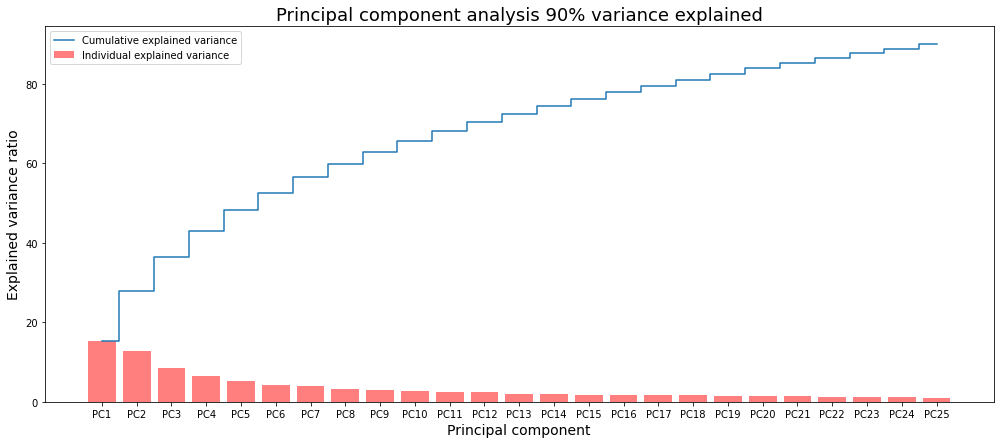

In [28]:
# Create the visualization 

percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)

cum_sum_eigenvalues = np.cumsum(percent_variance)

f, ax = plt.subplots(figsize=(14,6))
ax = plt.bar(range(0,len(percent_variance)), percent_variance, alpha=0.5, align='center', label='Individual explained variance', color='red')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio', fontsize=14)
plt.xlabel('Principal component', fontsize=14)
plt.xticks(np.arange(25), ('PC1', 'PC2', 'PC3', 'PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14','PC15'
                          ,'PC16','PC17','PC18','PC19','PC20','PC21','PC22','PC23','PC24','PC25'))
plt.legend(loc='best')
plt.tight_layout()
plt.title('Principal component analysis 90% variance explained', fontsize=18)
plt.show();

We see that approximately 15 components explain 80% of the variance and the compenents after that each contribute just a little

PCA loadings are the coefficients of the linear combination of the original variables from which the principal components (PCs) are constructed.


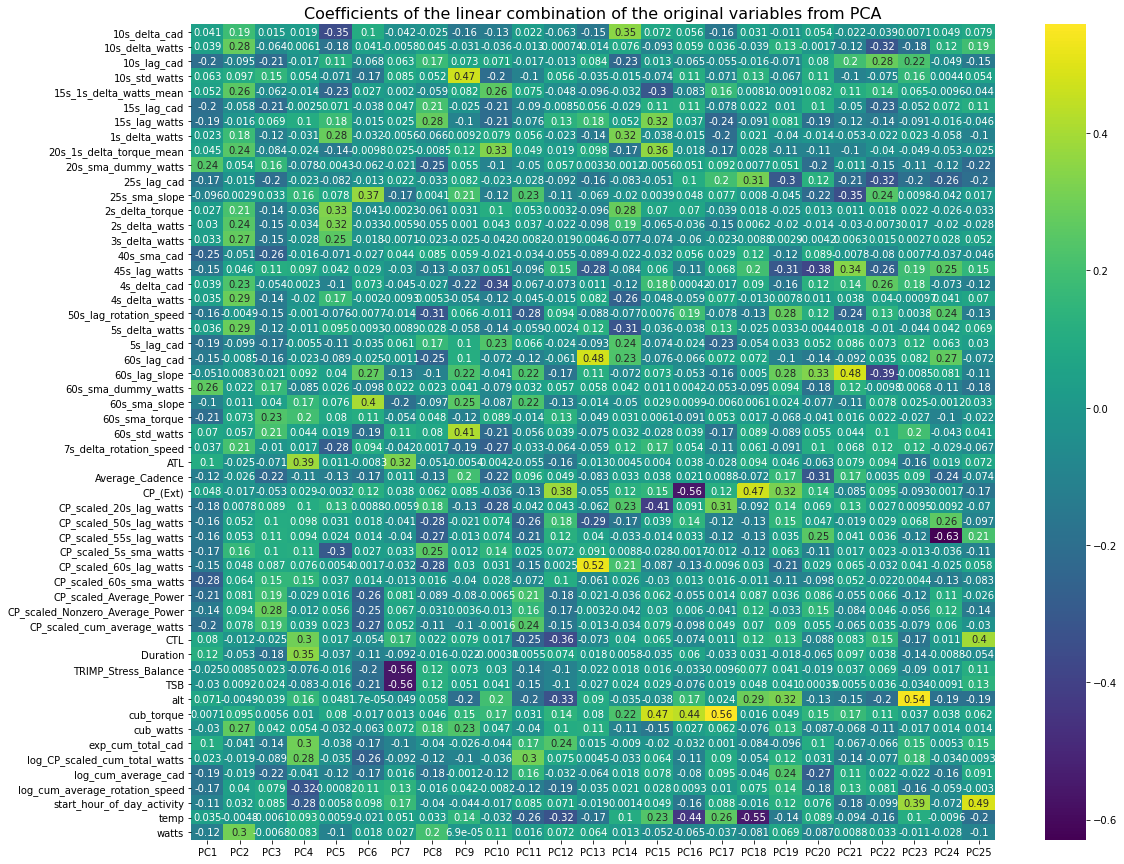

In [34]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2',
                                                   'PC3', 'PC4','PC5', 'PC6',
                                                   'PC7', 'PC8',
                                                   'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15'
                                                   ,'PC16','PC17','PC18','PC19','PC20','PC21','PC22'
                                                   ,'PC23','PC24','PC25'], index=X_feat[X_feat.columns[~X_feat.columns.isin(to_drop)]].columns)

print('PCA loadings are the coefficients of the linear combination of the original variables from which the principal components (PCs) are constructed.')

f, ax = plt.subplots(figsize=(18,15))
plt.title('Coefficients of the linear combination of the original variables from PCA', fontsize=16) 
sns.heatmap(loadings, annot=True, ax=ax, cmap='viridis' );

## Conclusion Feature importances

Based on the insights from various feature selection approaches we decide to take a _three_ approaches. 

(1) The first would be based on all the features coming from the feature selection approaches we had. Note that these approaches all have it's pros and cons and that there is no golden recipe to come to the "right"" features. We ended up with 140 features to be used for further modelling. 

The second (2) approach would be the "trimmed" down approach of our feature selection methods: we overlayed an extra "selection" layer based on deleting features which had a correlation of more than 0.9 between each other and keeping the feature which correlated more strongly with our target variable. 

The third (3) approach will be a more "pragmatic" approach with variables which could both from a theoretical and practical perspective be used a candidate features. This is not to say that some of these variables are not important: on contrary we confirmed that these variables do relate to heart rate during workouts. As such we see this as a "middle ground" between solely a machine learning pipeline where features are data driven and predictive power is king versus a model with features based on (some) more reasoning. The variables in the third approach wich we will include for further modelling are:

* Torque, rotation_speed as seperate components together with watts
* CP scaled cum average watts, cum average torque, cum average rotation speed 
(# cum total watts)
* 5/30/60 sec CP scaled lag watts : rationale: indicator for lagged watts (around 30 sec maximum correlation with heart rate)
* CP scaled 5/30/60 sma watts: rationale: indicator short term, mid term, long term HR changes 
* 5/30/60 sma torque: rationale: indicator for short term, mid term, long term HR changes 
* 5/30/60 sma rotation speed: rationale: indicator for short term, mid term, long term HR changes 
* 60 second std watts: standard deviations (variability) over 60s watts
* Slope & altitude: slope and altitude with sma 30s for slope
* Dummy watts : indicator for zero wattage (heart rate will (of not a data dropout) be depressed) and sma 60s
* CP ext, CP_scaled_NP_EMA : indicator for rider "current scaled wattage threshold" capability
* Time riding (total ride time), start hour activity, seconds in ride
* Relative Intensity, BikeScore, XPower, NonZero Average Power, Average Power, Average Cadence
* ATL, CTL, TSB : indicator for mechanical training load
* TRIMP_Short_Term_Stress, TRIMP_Long_Term_Stress, TRIMP_Stress_Balance: indicator for internal stress


_Extra comments_
* We have decided not to include temperature during the rides. We have 31 files which had no temperature recorded. Also from inspecting some of the rides temperature sometimes showed very unreliable patterns. This does not mean we do not see this as a possible predictor of heart rate dynamics, but merely that for reasons mentioned we don't use it here
* We also include some metrics which when used for planning multiple rides should be known when used as model inputs, more specifically the TRIMP internal training stress metrics. When applied for furture rides these could (or better said) should be estimated in advance while they are the result of the heart rate dynamics of the rides in time itself. In **5. Training stress calculations.ipynb** we test whether TRIMP ride level metrics can be estimated using our developed heart rate dynamics model or better by using some aggregate training metrics

In [ ]:
# Make the manual list
list_var_models_manual = ['filename','date','hr','secs','start_hour_of_day_activity','Time_Moving', 'Relative_Intensity', 'BikeScore','Nonzero_Average_Power', 'Average_Power','Average_Cadence','ATL','CTL','TSB','TRIMP_Short_Term_Stress','TRIMP_Long_Term_Stress','TRIMP_Stress_Balance',
 'CP_(Ext)','60s_std_watts','slope','30s_sma_slope','alt','CP_scaled_5s_lag_watts','CP_scaled_30s_lag_watts','CP_scaled_60s_lag_watts','CP_scaled_5s_sma_watts','CP_scaled_30s_sma_watts',
'CP_scaled_60s_sma_watts','5s_sma_torque', '30s_sma_torque', '60s_sma_torque','5s_sma_rotation_speed', '30s_sma_rotation_speed','60s_sma_rotation_speed','CP_scaled_cum_average_watts','cum_average_rotation_speed','dummy_zero_watts','60s_sma_dummy_watts','watts', 'rotation_speed','torque']

In [ ]:
# save the manual list

with open('list_var_models_manual.pkl', 'wb') as f:
    pickle.dump(list_var_models_manual, f)